## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import collections
#%matplotlib qt

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')


# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    print(fname)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        mpimg.imsave(fname[:-4] + '_corners_output.jpg', img)


img = cv2.imread(images[0])
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1::-1], None, None)

#save camera matrix and distrotion coefficients (since it's calculated once)
np.save('camera_matrix.npy', mtx)
np.save('distortion_coeffs.npy', dist) 

camera_cal/calibration3.jpg
camera_cal/calibration9.jpg
camera_cal/calibration12.jpg
camera_cal/calibration20.jpg
camera_cal/calibration18_corners_output.jpg
camera_cal/calibration12_corners_output.jpg
camera_cal/calibration16.jpg
camera_cal/calibration13.jpg
camera_cal/calibration14.jpg
camera_cal/calibration4.jpg
camera_cal/calibration20_corners_output.jpg
camera_cal/calibration6_corners_output.jpg
camera_cal/calibration7.jpg
camera_cal/calibration2.jpg
camera_cal/calibration3_corners_output.jpg
camera_cal/calibration11.jpg
camera_cal/calibration11_corners_output.jpg
camera_cal/calibration17.jpg
camera_cal/calibration1.jpg
camera_cal/calibration19.jpg
camera_cal/calibration2_corners_output.jpg
camera_cal/calibration10.jpg
camera_cal/calibration5.jpg
camera_cal/calibration19_corners_output.jpg
camera_cal/calibration3_corners_output_corners_output.jpg
camera_cal/calibration14_corners_output.jpg
camera_cal/calibration15_corners_output.jpg
camera_cal/calibration15.jpg
camera_cal/calibrat

In [4]:
#use np.load(base_dir + 'camera_matrix.npy') to load
mtx = np.load('camera_matrix.npy')
dist = np.load('distortion_coeffs.npy')

## Apply a distortion correction to raw images.

In [5]:
img = mpimg.imread('test_images/test2.jpg')

undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)

## Use color transforms, gradients, etc., to create a thresholded binary image.

In [3]:
def Color_Gradient_Combined_Edges(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
  
  # Convert to HLS color space and separate the S channel
  # img is the undistorted image
  hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
  s_channel = hls[:,:,2]

  # Explore gradients in other colors spaces / color channels (since standard grayscaling might lose color information for lane lines detection)
  # separate the L channel
  l_channel = hls[:,:,1]
  sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 

  # Sobel x
  abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
  scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

  # Threshold x gradient
  sxbinary = np.zeros_like(scaled_sobel)
  sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

  # Threshold color channel
  s_binary = np.zeros_like(s_channel)
  s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

  # Combine the two binary thresholds
  combined_binary = np.zeros_like(sxbinary)
  combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

  return combined_binary


In [34]:
combined_binary = Color_Gradient_Combined_Edges(undistorted_img, s_thresh=(170, 255), sx_thresh=(20, 100))

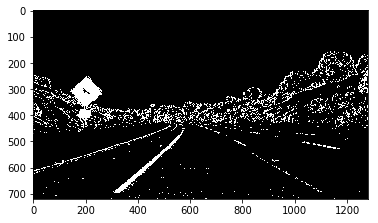

In [35]:
plt.imshow(combined_binary, cmap='gray')

## Apply a perspective transform to rectify binary image ("birds-eye view").
### Identify four source points (trapezoidal shape) by investigating an image where the lane lines are straight (*straight_lines1.jpg*).



In [4]:
src = np.float32([[190, img.shape[0]], [520, 500], [770, 500], [1135, img.shape[0]]])
dst = np.float32([[190, img.shape[0]], [190, 0], [1135, 0], [1135, img.shape[0]]])       

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)


In [37]:
#save transform matrix
np.save('perspective_transform.npy', M)

In [38]:
#M = np.load(base_dir + 'perspective_transform.npy')

In [29]:
Minv = cv2.getPerspectiveTransform(dst, src)  #np.linalg.inv(M)

In [40]:
#np.save(base_dir + 'perspective_InvTransform.npy', Minv)

In [6]:
def warper(img, src, dst):
    # Compute and apply perpective transform
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped

In [43]:
binary_warped = warper(combined_binary, src, dst)

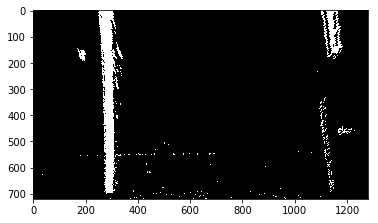

In [44]:
plt.imshow(binary_warped, cmap='gray')

In [7]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/(1135 - 190) # meters per pixel in x dimension

## Detect lane pixels and fit to find the lane boundary.

In [8]:
def find_lane_pixels_from_windows(binary_warped):
    # Take a histogram of the image
    histogram = np.sum(binary_warped[:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100 #50
    # Set minimum number of pixels found to recenter window
    minpix =  100 #50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window
        win_xleft_low = leftx_current - margin   
        win_xleft_high = leftx_current + margin  
        win_xright_low = rightx_current - margin  
        win_xright_high = rightx_current + margin  
        
        # Identify the nonzero pixels in x and y within the window 
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If  > minpix pixels, recenter next window 
        # (`right` or `leftx_current`) on their mean position 
        if len(good_left_inds) > minpix:
            leftx_current = int(nonzerox[good_left_inds].sum() / len(good_left_inds))
        
        if len(good_right_inds) > minpix:
            rightx_current = int(nonzerox[good_right_inds].sum() / len(good_right_inds))
        
    # Concatenate the arrays of indices (previously was a list of lists of pixels)
  
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty


In [9]:
def fit_polynomial(binary_warped, from_windows_flag = True, left_fit = np.zeros(3), right_fit = np.zeros(3)):
    
    # Find our lane pixels first
    if from_windows_flag:
      leftx, lefty, rightx, righty = find_lane_pixels_from_windows(binary_warped)
    else:
      leftx, lefty, rightx, righty = find_lane_pixels_from_prior(binary_warped, left_fit, right_fit)

    # Fit a second order polynomial to each using `np.polyfit` 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    return left_fit, right_fit, left_fitx, right_fitx, ploty


In [10]:
def fit_poly(img_shape, leftx, lefty, rightx, righty):
    # Fit a second order polynomial 
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    return left_fitx, right_fitx, ploty

In [11]:
def find_lane_pixels_from_prior(binary_warped, left_fit, right_fit):

    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Set the area of search based on activated x-values within the +/- margin of our polynomial function 
    left_lane_inds = ((nonzerox > left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] - margin) & (nonzerox <= left_fit[0]*nonzeroy**2 + left_fit[1]*nonzeroy + left_fit[2] + margin)).nonzero()[0]
    right_lane_inds = ((nonzerox > right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] - margin) & (nonzerox <= right_fit[0]*nonzeroy**2 + right_fit[1]*nonzeroy + right_fit[2] + margin)).nonzero()[0]
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty

## Determine the curvature of the lane and vehicle position with respect to center.

In [12]:
def measure_curvature_real(left_fit, right_fit, ploty):
  # Define y-value where we want radius of curvature by choosing the maximum y-value corresponding to the bottom of the image
  y_eval = np.max(ploty)
  left_fit_real = []
  
  # Convert best fit coefficients to real-world/meters scale
  left_fit_real = np.zeros_like(left_fit)
  left_fit_real[0] = xm_per_pix / (ym_per_pix**2) * left_fit[0]
  left_fit_real[1] = xm_per_pix / ym_per_pix * left_fit[1]
  left_fit_real[2] = left_fit[2]
  right_fit_real = np.zeros_like(left_fit)
  right_fit_real[0] = xm_per_pix / (ym_per_pix**2) * right_fit[0]
  right_fit_real[1] = xm_per_pix / ym_per_pix * right_fit[1]
  right_fit_real[2] = right_fit[2]

  # R_curve (radius of curvature)
  left_curverad = (1 + (2*left_fit_real[0]*y_eval*ym_per_pix + left_fit_real[1])**2)**1.5 / (2*np.abs(left_fit_real[0]))  
  right_curverad = (1 + (2*right_fit_real[0]*y_eval*ym_per_pix + right_fit_real[1])**2)**1.5 / (2*np.abs(right_fit_real[0]))  

  # return average curvature of left/right lanes
  return int((left_curverad + right_curverad) / 2)


In [13]:
def offset_real(image_width, image_height, left_fit, right_fit):
    
  image_center = image_width / 2
  
  lane_lower_left = left_fit[0]*image_height**2 + left_fit[1]*image_height + left_fit[2]
  lane_lower_right = right_fit[0]*image_height**2 + right_fit[1]*image_height + right_fit[2]

  lane_center = (lane_lower_left + lane_lower_right) / 2

  return (image_center - lane_center) * xm_per_pix


In [14]:
def project_back_to_original(undist, warped, left_fitx, right_fitx, ploty):
  # Create an image to draw the lines on
  warp_zero = np.zeros_like(warped).astype(np.uint8)
  color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

  # Recast the x and y points into usable format for cv2.fillPoly()
  pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
  pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
  pts = np.hstack((pts_left, pts_right))

  # Draw the lane onto the warped blank image
  cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

  # Warp the blank back to original image space using inverse perspective matrix (Minv)
  newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
  # Combine the result with the original image
  result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)

  return result

In [15]:
def add_info_offset_curvature(output_unlabled, curvature, offset):
  
  position = 'left' if offset < 0 else 'right'

  # font 
  font = cv2.FONT_HERSHEY_SIMPLEX 
    
  # org 
  org = (50, 50)

  org2 = (50, 100) 
    
  # fontScale 
  fontScale = 1
    
  # White color 
  color = (255, 255, 255) 
    
  # Line thickness of 2 px 
  thickness = 2
    
  # Using cv2.putText() method 
  final_image = cv2.putText(output_unlabled, f"Radius of Curvature = {curvature}m", org, font,  
                    fontScale, color, thickness, cv2.LINE_AA) 
  final_image = cv2.putText(output_unlabled, f'Vehicle is {abs(offset):.2f}m {position} of center', org2, font,  
                    fontScale, color, thickness, cv2.LINE_AA)
  
  return final_image


In [1]:
# exponential smoothing 
# y_t = a * y_t + a * (1-a)^1 * y_{t-1} + a * (1-a)^2 * y_{t-2} + ... + a*(1-a)^n * 
# y_{t-n}

def exponential_smoothing(input_series, alpha_value):
    output=sum([alpha_value * (1 - alpha_value) ** i * x for i, x in 
                enumerate(reversed(input_series))])
    
    return output

In [16]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        
        # frame count
        self.frame = 0

        # polynomial coeffs history
        self.poly_fit = collections.deque()

        # curvature history
        self.curvature_history = collections.deque()

    def smoothed_poly_fit(self, history_length):
      return sum(list(self.poly_fit)[-history_length:]) / len(list(self.poly_fit)[-history_length:])

    def exp_smoothed_poly_fit(self, history_length, alpha):
        return exponential_smoothing(list(self.poly_fit)[-history_length:], alpha)
    
    

In [38]:
left_Lane = Line()
right_Lane = Line()

In [39]:
def process_image(image):

  left_Lane.frame += 1

  undistorted_img = cv2.undistort(image, mtx, dist, None, mtx)
  
  combined_binary = Color_Gradient_Combined_Edges(undistorted_img, s_thresh=(170, 255), sx_thresh=(20, 100))
  
  binary_warped = warper(combined_binary, src, dst)
  
  n_from_windows = 24
  
  if left_Lane.frame < n_from_windows:  # Initialize by 'from_windows' method over the first 25 frames (~1 second of video)
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped, from_windows_flag = True)
    left_Lane.poly_fit.append(left_fit)
    right_Lane.poly_fit.append(right_fit)
  else:
    # Calculate smoothed prior as an average over the most recent ~0.5 seconds history
    prior_history = 18
    smoothed_prior_left = left_Lane.smoothed_poly_fit(prior_history)
    smoothed_prior_right = right_Lane.smoothed_poly_fit(prior_history)
    left_fit, right_fit, left_fitx, right_fitx, ploty = fit_polynomial(binary_warped, from_windows_flag = False, left_fit = smoothed_prior_left, right_fit = smoothed_prior_right)
    left_Lane.poly_fit.popleft()
    left_Lane.poly_fit.append(left_fit)
    right_Lane.poly_fit.popleft()
    right_Lane.poly_fit.append(right_fit)

    # Calculate final line as smoothed quadratics over the most recent ~0.5 seconds history (including)
    n_prior_poly_fit = 18
    smoothed_fit_left = left_Lane.smoothed_poly_fit(n_prior_poly_fit)
    smoothed_fit_right = right_Lane.smoothed_poly_fit(n_prior_poly_fit)
    left_fitx = smoothed_fit_left[0]*ploty**2 + smoothed_fit_left[1]*ploty + smoothed_fit_left[2]
    right_fitx = smoothed_fit_right[0]*ploty**2 + smoothed_fit_right[1]*ploty + smoothed_fit_right[2]
  
  output_unlabled = project_back_to_original(undistorted_img, binary_warped, left_fitx, right_fitx, ploty)

  curvature = measure_curvature_real(left_fit, right_fit, ploty)

  offset = offset_real(image.shape[1], image.shape[0], left_fit, right_fit)

  final_image = add_info_offset_curvature(output_unlabled, curvature, offset)

  return final_image

In [40]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
#clip1 = VideoFileClip(base_dir +"project_video.mp4").subclip(0, seconds)
#seconds = 12
clip1 = VideoFileClip("project_video.mp4")#.subclip(0, seconds)
#video_output = base_dir + f'output_images/project_video_output_{seconds}seconds.mp4'
video_output = 'output_images/project_video_output.mp4'
output_clip = clip1.fl_image(process_image) 
%time output_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video output_images/project_video_output.mp4
[MoviePy] Writing video output_images/project_video_output.mp4


100%|█████████▉| 1260/1261 [03:54<00:00,  5.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_images/project_video_output.mp4 

CPU times: user 1min 37s, sys: 14.8 s, total: 1min 52s
Wall time: 3min 57s
